In [1]:
import cirq
from typing import Sequence, Tuple
import numpy as np
import sympy
import matplotlib.pyplot as plt

In [2]:
"""Example of using the ZZ gate."""
# Get two qubits.
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

# Pick a value for gamma.
gamma = 0.3

# Display the circuit.
circuit = cirq.Circuit(cirq.ZZ(a, b) ** gamma)
print(circuit)

a: ───ZZ───────
      │
b: ───ZZ^0.3───


In [3]:
"""Check the unitary of the ZZ gate."""
# Unitary we want to implement.
expected_unitary = np.array(
    [
        [np.exp(-1j * np.pi * gamma / 2), 0, 0, 0],
        [0, np.exp(1j * np.pi * gamma / 2), 0, 0],
        [0, 0, np.exp(1j * np.pi * gamma / 2), 0],
        [0, 0, 0, np.exp(-1j * np.pi * gamma / 2)],
    ]
)

# Unitary we are implementing.
actual_unitary = cirq.unitary(circuit)

# Check that they are equal up to global phase.
cirq.testing.assert_allclose_up_to_global_phase(
    actual_unitary, expected_unitary, atol=1e-5
)

In [4]:
"""Example of using the Z gate."""
# Value of the external magenetic field.
h = 1.3

# Display the circuit.
circuit = cirq.Circuit(cirq.Z(a) ** (gamma * h))
print(circuit)

a: ───Z^0.39───


In [5]:
"""Check the unitary of the Z gate."""
# Unitary we want to implement.
expected_unitary = np.array(
    [[np.exp(-1j * np.pi * gamma * h / 2), 0], [0, np.exp(1j * np.pi * gamma * h / 2)]]
)

# Unitary we are implementing.
actual_unitary = cirq.unitary(circuit)

# Check that they are equal up to global phase.
cirq.testing.assert_allclose_up_to_global_phase(
    expected_unitary, actual_unitary, atol=1e-5
)

In [6]:
"""Define problem parameters and get a set of GridQubits."""
# Set the dimensions of the grid.
n_cols = 3
n_rows = 3

# Set the value of the external magnetic field at each site.
h = 0.5 * np.ones((n_rows, n_cols))

# Arranging the qubits in a list-of-lists like this makes them easy to refer to later.
qubits = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]

In [7]:
def gamma_layer(gamma_value: float, h: np.ndarray) -> Sequence[cirq.Operation]:
    """Generator for U(gamma, C) layer of QAOA

    Args:
        gamma: Float variational parameter for the circuit
        h: Array of floats of external magnetic field values
    """
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                yield cirq.ZZ(qubits[i][j], qubits[i + 1][j]) ** gamma_value
            if j < n_cols - 1:
                yield cirq.ZZ(qubits[i][j], qubits[i][j + 1]) ** gamma_value
            yield cirq.Z(qubits[i][j]) ** (gamma_value * h[i, j])

In [8]:
def beta_layer(beta_value: float) -> Sequence[cirq.Operation]:
    """Generator for U(beta, B) layer (mixing layer) of QAOA"""
    for row in qubits:
        for qubit in row:
            yield cirq.X(qubit) ** beta_value

In [10]:
"""Create the QAOA circuit."""
# Use sympy.Symbols for the 𝛾 and β parameters.
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")

# Start in the H|0> state.
qaoa = cirq.Circuit(cirq.H.on_each(qubits))

# Implement the U(gamma, C) operator.
qaoa.append(gamma_layer(gamma, h))

# Implement the U(beta, B) operator.
qaoa.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# Display the QAOA circuit.
qaoa

┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ───────ZZ───────Z^(0.5*𝛄)──────────────────────────────────────────────────────────────────────────────────────────────X^(β)───
               │        │
(0, 1): ───H───┼────────ZZ^(𝛄)───ZZ──────────ZZ────────Z^(0.5*𝛄)────────────────────────────────────────────────────────────────────────X^(β)───
               │                 │           │
(0, 2): ───H───┼─────────────────┼───────────ZZ^(𝛄)────ZZ────────────────────Z^(0.5*𝛄)──────────────────────────────────────────────────X^(β)───
               │                 │                     │
(1, 0): ───H───ZZ^(𝛄)───ZZ───────┼───────────ZZ────────┼────────Z^(0.5*𝛄)───────────────────────────────────────────────────────────────X^(β)───
                        │        │           │         │
(1, 1): ───H────────────┼────────ZZ^(𝛄)──────ZZ^(𝛄)────┼────────ZZ───────────ZZ───────────Z^(0.5*𝛄)─────────────────────────────────────X^(β)───
                        │                              │        │            │
(1, 2): ───H────────────┼──────────────────────────────ZZ^(𝛄)───┼────────────ZZ^(𝛄)───────ZZ────────────────────Z^(0.5*𝛄)───────────────X^(β)───
                        │                                       │                         │
(2, 0): ───H────────────ZZ^(𝛄)──────────────────────────────────┼────────────ZZ───────────┼────────Z^(0.5*𝛄)────────────────────────────X^(β)───
                                                                │            │            │
(2, 1): ───H────────────────────────────────────────────────────ZZ^(𝛄)───────ZZ^(𝛄)───────┼─────────────────────ZZ──────────Z^(0.5*𝛄)───X^(β)───
                                                                                          │                     │
(2, 2): ───H──────────────────────────────────────────────────────────────────────────────ZZ^(𝛄)────────────────ZZ^(𝛄)──────Z^(0.5*𝛄)───X^(β)───
                                                      └──────────────────┘               └──────────────────┘

In [11]:
def energy_from_wavefunction(wf: np.ndarray, h: np.ndarray) -> float:
    """Computes the energy-per-site of the Ising model directly from the
    a given wavefunction.

    Args:
        wf: Array of size 2**(n_rows * n_cols) specifying the wavefunction.
        h: Array of shape (n_rows, n_cols) giving the magnetic field values.

    Returns:
        energy: Float equal to the expectation value of the energy per site
    """
    n_sites = n_rows * n_cols

    # Z is an array of shape (n_sites, 2**n_sites). Each row consists of the
    # 2**n_sites non-zero entries in the operator that is the Pauli-Z matrix on
    # one of the qubits times the identities on the other qubits. The
    # (i*n_cols + j)th row corresponds to qubit (i,j).
    Z = np.array(
        [(-1) ** (np.arange(2**n_sites) >> i) for i in range(n_sites - 1, -1, -1)]
    )

    # Create the operator corresponding to the interaction energy summed over all
    # nearest-neighbor pairs of qubits
    ZZ_filter = np.zeros_like(wf, dtype=float)
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                ZZ_filter += Z[i * n_cols + j] * Z[(i + 1) * n_cols + j]
            if j < n_cols - 1:
                ZZ_filter += Z[i * n_cols + j] * Z[i * n_cols + (j + 1)]

    energy_operator = -ZZ_filter - h.reshape(n_sites).dot(Z)

    # Expectation value of the energy divided by the number of sites
    return np.sum(np.abs(wf) ** 2 * energy_operator) / n_sites

In [12]:
def energy_from_params(
    gamma_value: float, beta_value: float, qaoa: cirq.Circuit, h: np.ndarray
) -> float:
    """Returns the energy given values of the parameters."""
    sim = cirq.Simulator()
    params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
    wf = sim.simulate(qaoa, param_resolver=params).final_state_vector
    return energy_from_wavefunction(wf, h)

In [13]:
"""Do a grid search over values of 𝛄 and β."""
# Set the grid size and range of parameters.
grid_size = 50
gamma_max = 2
beta_max = 2

# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        energies[i, j] = energy_from_params(
            i * gamma_max / grid_size, j * beta_max / grid_size, qaoa, h
        )

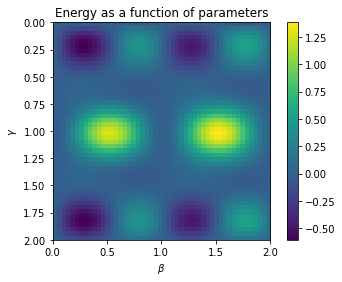

In [14]:
"""Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
plt.title("Energy as a function of parameters")
plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
plt.colorbar()
plt.show()

In [15]:
def gradient_energy(
    gamma: float, beta: float, qaoa: cirq.Circuit, h: np.ndarray
) -> Tuple[float, float]:
    """Uses a symmetric difference to calulate the gradient."""
    eps = 10**-3  # Try different values of the discretization parameter

    # Gamma-component of the gradient
    grad_g = energy_from_params(gamma + eps, beta, qaoa, h)
    grad_g -= energy_from_params(gamma - eps, beta, qaoa, h)
    grad_g /= 2 * eps

    # Beta-compoonent of the gradient
    grad_b = energy_from_params(gamma, beta + eps, qaoa, h)
    grad_b -= energy_from_params(gamma, beta - eps, qaoa, h)
    grad_b /= 2 * eps

    return grad_g, grad_b

In [16]:
"""Run a simple gradient descent optimizer."""
gamma, beta = 0.2, 0.7  # Try different initializations
eta = 10**-2  # Try adjusting the learning rate.

# Perform gradient descent for a given number of steps.
num_steps = 150
for i in range(num_steps + 1):
    # Compute the gradient.
    grad_g, grad_b = gradient_energy(gamma, beta, qaoa, h)

    # Update the parameters.
    gamma -= eta * grad_g
    beta -= eta * grad_b

    # Status updates.
    if not i % 25:
        print("Step: {} Energy: {}".format(i, energy_from_params(gamma, beta, qaoa, h)))

print("\nLearned gamma: {}\nLearned beta: {}".format(gamma, beta, qaoa, h))

Step: 0 Energy: 0.35551795996348623
Step: 25 Energy: -0.6065682760005429
Step: 50 Energy: -0.6068781635796969
Step: 75 Energy: -0.6068779948701982
Step: 100 Energy: -0.6068779526168934
Step: 125 Energy: -0.606878341706508
Step: 150 Energy: -0.6068780815188196

Learned gamma: 0.19753264071127577
Learned beta: 0.26843984831165874


In [17]:
"""Add measurements to the QAOA circuit."""
measurement_circuit = qaoa.copy()
measurement_circuit.append(
    cirq.measure(*[qubit for row in qubits for qubit in row], key="m")
)
measurement_circuit

┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ───────ZZ───────Z^(0.5*𝛄)──────────────────────────────────────────────────────────────────────────────────────────────X^(β)───M('m')───
               │        │                                                                                                                       │
(0, 1): ───H───┼────────ZZ^(𝛄)───ZZ──────────ZZ────────Z^(0.5*𝛄)────────────────────────────────────────────────────────────────────────X^(β)───M────────
               │                 │           │                                                                                                  │
(0, 2): ───H───┼─────────────────┼───────────ZZ^(𝛄)────ZZ────────────────────Z^(0.5*𝛄)──────────────────────────────────────────────────X^(β)───M────────
               │                 │                     │                                                                                        │
(1, 0): ───H───ZZ^(𝛄)───ZZ───────┼───────────ZZ────────┼────────Z^(0.5*𝛄)───────────────────────────────────────────────────────────────X^(β)───M────────
                        │        │           │         │                                                                                        │
(1, 1): ───H────────────┼────────ZZ^(𝛄)──────ZZ^(𝛄)────┼────────ZZ───────────ZZ───────────Z^(0.5*𝛄)─────────────────────────────────────X^(β)───M────────
                        │                              │        │            │                                                                  │
(1, 2): ───H────────────┼──────────────────────────────ZZ^(𝛄)───┼────────────ZZ^(𝛄)───────ZZ────────────────────Z^(0.5*𝛄)───────────────X^(β)───M────────
                        │                                       │                         │                                                     │
(2, 0): ───H────────────ZZ^(𝛄)──────────────────────────────────┼────────────ZZ───────────┼────────Z^(0.5*𝛄)────────────────────────────X^(β)───M────────
                                                                │            │            │                                                     │
(2, 1): ───H────────────────────────────────────────────────────ZZ^(𝛄)───────ZZ^(𝛄)───────┼─────────────────────ZZ──────────Z^(0.5*𝛄)───X^(β)───M────────
                                                                                          │                     │                               │
(2, 2): ───H──────────────────────────────────────────────────────────────────────────────ZZ^(𝛄)────────────────ZZ^(𝛄)──────Z^(0.5*𝛄)───X^(β)───M────────
                                                      └──────────────────┘               └──────────────────┘

In [18]:
"""Sample from the QAOA circuit."""
num_reps = 1000  # Try different numbers of repetitions.
gamma_value, beta_value = 0.2, 0.25  # Try different values of the parameters.

# Sample from the circuit.
simulator = cirq.Simulator()
params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
result = simulator.run(measurement_circuit, param_resolver=params, repetitions=num_reps)

In [19]:
def compute_energy(meas: np.ndarray) -> float:
    """Returns the energy computed from measurements.

    Args:
        meas: Measurements/samples.
    """
    Z_vals = 1 - 2 * meas.reshape(n_rows, n_cols)
    energy = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                energy -= Z_vals[i, j] * Z_vals[i + 1, j]
            if j < n_cols - 1:
                energy -= Z_vals[i, j] * Z_vals[i, j + 1]
            energy -= h[i, j] * Z_vals[i, j]
    return energy / (n_rows * n_cols)

In [20]:
"""Compute the energies of the most common measurement results."""
# Get a histogram of the measurement results.
hist = result.histogram(key="m")

# Consider the top 10 of them.
num = 10

# Get the most common measurement results and their probabilities.
configs = [c for c, _ in hist.most_common(num)]
probs = [v / result.repetitions for _, v in hist.most_common(num)]

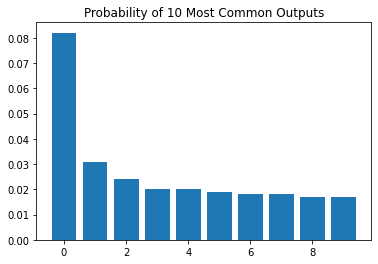

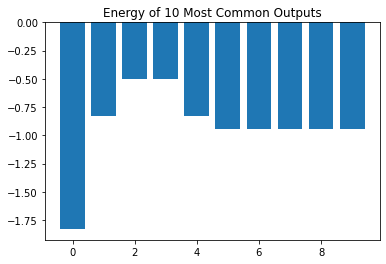

Fraction of outputs displayed: 0.27


In [21]:
"""Plot the most common measurement results and their energies."""
# Plot probabilities of the most common bitstrings.
plt.title("Probability of {} Most Common Outputs".format(num))
plt.bar([x for x in range(len(probs))], probs)
plt.show()
meas = [
    [int(s) for s in "".join([str(b) for b in bin(k)[2:]]).zfill(n_rows * n_cols)]
    for k in configs
]
costs = [compute_energy(np.array(m)) for m in meas]

# Plot energies of the most common bitstrings.
plt.title("Energy of {} Most Common Outputs".format(num))
plt.bar([x for x in range(len(costs))], costs)
plt.show()
print("Fraction of outputs displayed: {}".format(np.sum(probs).round(2)))